## 합성곱 계층 구현하기

In [1]:
import numpy as np
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7) # (데이터 수, 채널 수, 높이, 너비)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [2]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # 필터 전개
        out = np.dot(col, col_W) + self.b

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        return out

## 풀링 계층 구현하기

In [3]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        # 전개 (1) 
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        # 최댓값 (2)
        out = np.max(col, axis=1)

        # 성형 (3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out

## CNN 구현하기

In [32]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.3006443283737505
=== epoch:1, train acc:0.352, test acc:0.377 ===
train loss:2.2979185243794746
train loss:2.294107260620207
train loss:2.2916734181269036
train loss:2.284025898080454
train loss:2.2777414964885896
train loss:2.262337236342923
train loss:2.2550088306094183
train loss:2.2391800079507562
train loss:2.1948756501134965
train loss:2.2031837279435167
train loss:2.1813516066610843
train loss:2.184815756202939
train loss:2.070075239088478
train loss:2.030585061717547
train loss:2.0170556488324958
train loss:1.9603726431341126
train loss:1.937270073974872
train loss:1.838792907476807
train loss:1.7075676537038682
train loss:1.6674669851467883
train loss:1.5635902148527803
train loss:1.531217019439251
train loss:1.4189557524072405
train loss:1.3778027446704657
train loss:1.2793768076920997
train loss:1.1901726626575708
train loss:1.055243533254614
train loss:1.184735228063401
train loss:1.0171104602143195
train loss:0.9560595580940465
train loss:0.9120084545958882
tr

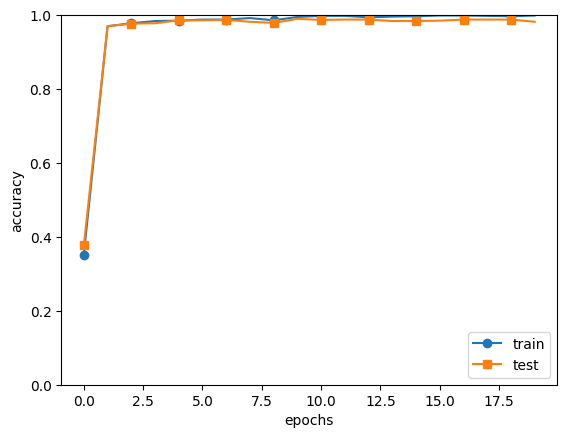

In [33]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## CNN 시각화하기

In [ ]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])